# Notebook version of First Neural Network

This is a step-by-step implementation of the first neural network using MNIST dataset without neural network framework.  



In [15]:
import sys, os
import os.path
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

### Definition of fundamental functions used in this example.

(function.py)

In [7]:
# functions
 
def identity_function(x):
    return x

def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros_like(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # countermeasure against overflow
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


def sum_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # when training data is one-hot vector
    #    convert it into label index (ex) [0,0,1,0] -> 2
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)


### Definition of two layer (traditional three layer) neural networks.  

input-hidden[sigmoid]-output[softmax]  

use cross-entropy loss


In [8]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # init weight
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:input data, t:training data
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:input data, t:training data
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

### Functions for loading and managing MNIST dataset

Download four gziped file, convert each of them to numpy array, concatenate and pickled them, and save it as mnist.pkl.

(mnist.py)

step-by-step definition for further application  
you can modify this when you build your own dataset and use.

In [9]:
## load MNIST dataset

from pathlib import Path
import requests
import pickle
import gzip

url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

#dataset_dir = os.path.dirname(os.path.abspath(__file__))
dataset_dir = os.path.dirname(os.path.abspath('./data/'))
# __file__ is the name of the involed file [mnist.py]
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done: labels.shape= ", labels.shape)

    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done: data.shape= ",data.shape)

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("***** saved MNIST dataset in ",save_file,"*****")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """load MNIST dataset
    Parameters
    ----------
    normalize : normalize pixel value into [0,1]
    one_hot_label :
        if one_hot_label is True  return label as one-hot array
        one-hot array:  (ex) [0,0,1,0,0,0,0,0,0,0]
    flatten : if enable, image is converted into one-dim array
    Returns
    -------
    (training image, training label), (test image, test label)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), \
        (dataset['test_img'], dataset['test_label'])

# check whether program is involed from command prompt
# if true: run init_mnist(), 
#    otherwise (ex: "import mnist" from other code, do nothing)
#if __name__ == '__main__': 
init_mnist()

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done: data.shape=  (60000, 784)
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done: labels.shape=  (60000,)
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done: data.shape=  (10000, 784)
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done: labels.shape=  (10000,)
Creating pickle file ...
***** saved MNIST dataset in  /content/mnist.pkl *****


### Download MNIST dataset and set them to numpy array format using load_mnist function

Shape of x_train is: (60000, 784)
label of x_train[0] is: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


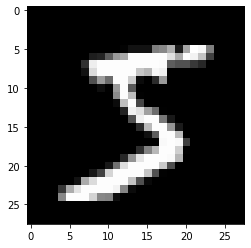

In [16]:
# read data and stored them into numpy array
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# visualize first data
print(f'Shape of x_train is: {x_train.shape}')
print(f'label of x_train[0] is: {t_train[0]}')
plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")

### Alternatively, you can use this. 
(different data source)

This is much shorter.   
But this depends on the composition of the data source file. The previous example is easier to understand what exactly you are doing.

In [ ]:
### OR use this 

# OR you can use following 
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        print(type(f))
        ((x_train2, y_train2), (x_test2, y_test2), _) = pickle.load(f, encoding="latin-1")

pyplot.imshow(x_train2[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)


### Definition of the network

You can modify number of hidden_size (i.e. number of neurons in the intermediate layer).  

You cannot modify the numbers of input and output.


In [11]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000   # set the number of training iteration
train_size = x_train.shape[0]
batch_size = 100    # set the batch size
learning_rate = 0.1 # set the learning rate at gradient descent

train_loss_list = []
train_acc_list = []
test_acc_list = []

### Training the network

If you download MNIST dataset from github (second example), rephrase x_train ==> x_train2 and so on.

In [12]:
iter_per_epoch = max(train_size / batch_size, 1) 
# 600 iterations/epoch (or 500 iterations/epoch from github dataset)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # calculate gradients (choose either one - usually take the latter)
    ####################################################################
    #                   grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    ####################################################################
    
    # update weights
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        #print("train acc, test acc | {:.4f} {:.4f}".format(train_acc, test_acc))
        print(f'epoch={int(i/iter_per_epoch): >2} | num_iterations = {i: >5} | train acc = {train_acc:.4f}, test acc = {test_acc:.4f}')

epoch= 0 | num_iterations =     0 | train acc = 0.0903, test acc = 0.0892
epoch= 1 | num_iterations =   600 | train acc = 0.7847, test acc = 0.7873
epoch= 2 | num_iterations =  1200 | train acc = 0.8747, test acc = 0.8777
epoch= 3 | num_iterations =  1800 | train acc = 0.8980, test acc = 0.9011
epoch= 4 | num_iterations =  2400 | train acc = 0.9081, test acc = 0.9100
epoch= 5 | num_iterations =  3000 | train acc = 0.9143, test acc = 0.9166
epoch= 6 | num_iterations =  3600 | train acc = 0.9200, test acc = 0.9213
epoch= 7 | num_iterations =  4200 | train acc = 0.9246, test acc = 0.9246
epoch= 8 | num_iterations =  4800 | train acc = 0.9273, test acc = 0.9282
epoch= 9 | num_iterations =  5400 | train acc = 0.9301, test acc = 0.9315
epoch=10 | num_iterations =  6000 | train acc = 0.9330, test acc = 0.9329
epoch=11 | num_iterations =  6600 | train acc = 0.9361, test acc = 0.9362
epoch=12 | num_iterations =  7200 | train acc = 0.9382, test acc = 0.9379
epoch=13 | num_iterations =  7800 | tr

### Draw a training curve

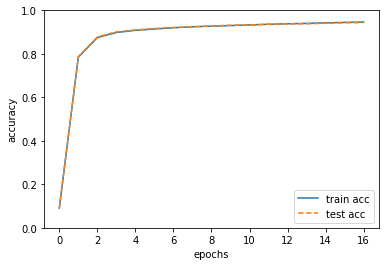

In [17]:
# draw graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()